In [1]:
import os
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
import tensorflow as tf

input_dir = "images"
target_dir = "masks"
img_size = (160, 160)
num_classes = 3
batch_size = 1

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

ModuleNotFoundError: No module named 'tensorflow.python'

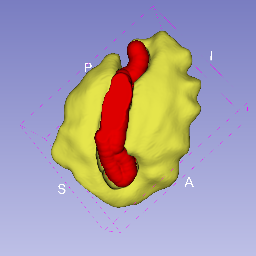

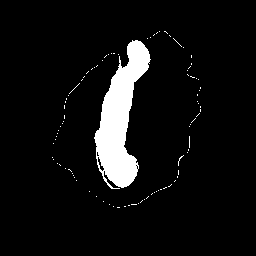

In [67]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

# Display input image #7
input_image = Image(filename=input_img_paths[9])
display(input_image)


# Display auto-contrast version of corresponding target (per-pixel categories)
target_image = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(target_image)



In [44]:
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
import tensorflow as tf

def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")
        input_img = tf.cast(input_img, tf.float32) / 255.0
        
        
        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        # target_img -= 2
        target_img = tf.where(target_img > 0, 1, 0)
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

In [45]:
from keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 160, 160,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 80, 80,    │     896 │ input_layer_6[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │     128 │ conv2d_54[0][0]      │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_90       │ (None, 80, 80,    │       0 │ batch_normalization… │
│ (Activation)        │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_91       │ (None, 80, 80,    │       0 │ activation_90[0][0]  │
│ (Activation)        │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ separable_conv2d_36 │ (None, 80, 80,    │   2,400 │ activation_91[0][0]  │
│ (SeparableConv2D)   │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │     256 │ separable_conv2d_36… │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_92       │ (None, 80, 80,    │       0 │ batch_normalization… │
│ (Activation)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ separable_conv2d_37 │ (None, 80, 80,    │   4,736 │ activation_92[0][0]  │
│ (SeparableConv2D)   │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │     256 │ separable_conv2d_37… │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_18    │ (None, 40, 40,    │       0 │ batch_normalization… │
│ (MaxPooling2D)      │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 40, 40,    │   2,112 │ activation_90[0][0]  │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ add_42 (Add)        │ (None, 40, 40,    │       0 │ max_pooling2d_18[0]… │
│                     │ 64)               │         │ conv2d_55[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_93       │ (None, 40, 40,    │       0 │ add_42[0][0]         │
│ (Activation)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ separable_conv2d_38 │ (None, 40, 40,    │   8,896 │ activation_93[0][0]  │
│ (SeparableConv2D)   │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │     512 │ separable_conv2d_38… │
│ (BatchNormalizatio… │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_94       │ (None, 40, 40,    │       0 │ batch_normalization

 Total params: 2,058,979 (7.85 MB)

 Trainable params: 2,055,203 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [46]:
import random

# Split our img paths into a training and a validation set
val_samples = 4
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=23,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

In [47]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 50
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/50


17/17 - 24s - 1s/step - loss: 0.5504 - val_loss: 2.9470
Epoch 2/50
17/17 - 2s - 128ms/step - loss: 0.1514 - val_loss: 0.8131
Epoch 3/50
17/17 - 2s - 116ms/step - loss: 0.1183 - val_loss: 0.2281
Epoch 4/50
17/17 - 2s - 119ms/step - loss: 0.1218 - val_loss: 0.2235
Epoch 5/50
17/17 - 2s - 92ms/step - loss: 0.1929 - val_loss: 0.3039
Epoch 6/50
17/17 - 2s - 97ms/step - loss: 0.1418 - val_loss: 0.3786
Epoch 7/50
17/17 - 2s - 93ms/step - loss: 0.1278 - val_loss: 0.3681
Epoch 8/50
17/17 - 2s - 95ms/step - loss: 0.0945 - val_loss: 0.3762
Epoch 9/50
17/17 - 2s - 106ms/step - loss: 0.0592 - val_loss: 0.4183
Epoch 10/50
17/17 - 2s - 106ms/step - loss: 0.0466 - val_loss: 0.4534
Epoch 11/50
17/17 - 2s - 108ms/step - loss: 0.0364 - val_loss: 0.4781
Epoch 12/50
17/17 - 2s - 110ms/step - loss: 0.0318 - val_loss: 0.4981
Epoch 13/50
17/17 - 2s - 108ms/step - loss: 0.0288 - val_loss: 0.5147
Epoch 14/50
17/17 - 2s - 104ms/step - loss: 0.0275 - val_loss: 0.5297
Epoch 15/50
17/17 - 2s - 130ms/step - loss: 0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


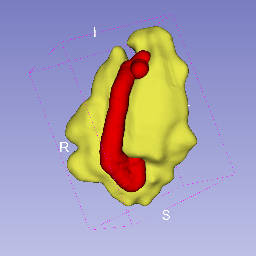

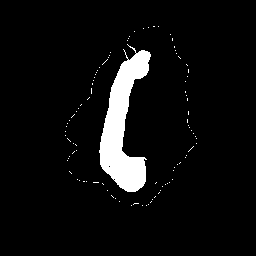

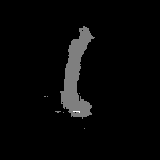

In [59]:
# Generate predictions for all images in the validation set

val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
val_preds = model.predict(val_dataset)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)


# Display results for validation image #5
i = 3

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


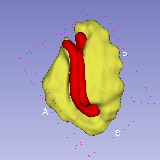

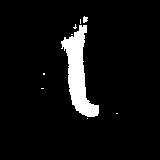

In [65]:
from PIL import ImageOps
from keras.preprocessing import image as keras_image

from PIL import ImageOps

# Load the new image
input_img_path = "Data/images/o21.png"
input_img = tf_io.read_file(input_img_path)
input_img = tf_io.decode_png(input_img, channels=3)
input_img = tf_image.resize(input_img, img_size)
input_img = tf_image.convert_image_dtype(input_img, "float32")

# Reshape the input image to match the model's input shape for a single image
input_img = tf.expand_dims(input_img, axis=0)

# Generate prediction for the input image
pred = model.predict(input_img)

# Remove the batch dimension from the prediction
pred = pred[0]

# Display the input image
input_image_display = keras_image.load_img(input_img_path, target_size=img_size)
display(input_image_display)

# Define the function to display the mask predicted by the model
def display_mask(prediction):
    mask = np.argmax(prediction, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    mask_image = ImageOps.autocontrast(keras_image.array_to_img(mask))
    display(mask_image)

# Display the mask predicted by the model
display_mask(pred)

